## Carga de imágenes


git@github.com:guiwitz/PyImageCourse_beginner.git


Puse un par de ejemplos que mandó Marcel

In [1]:
import matplotlib.pyplot as plt
import numpy as np
#from scipy import cluster
from sklearn.cluster import KMeans,DBSCAN
import skimage.io as imgio
import skimage.color as imgcolor



## Carga y recorte

La imagen es una versión reducida a 1/4 en cadad dimensión (1/16 de pixeles). En realidad creo que se puede reducir aún más sin afectar los resultados.

Además no nos interesa la parte de más abajo, que siempre va a ser tierra y el tallo (creo).



In [3]:
Irgb = imgio.imread('http://iie.fing.edu.uy/~nacho/cursos/agro/frame_crudo.jpg')


downsample = 4

Irgb =(Irgb[:-250:downsample,::downsample,:]/255).astype(float) # a la mitad en cada dim

## Clustering

Transformamos la imagen a HSV. Esta transformación _no lineal_ (eso es importante, porque modifica las distancias en el espacio) es más acorde a la percepción humana. No es que eso sea necesario en este caso, pero al parecer el tono de las uvas es algo distintivo. Podría no usarse y hacerse sólo con la imagen original en RGB también.


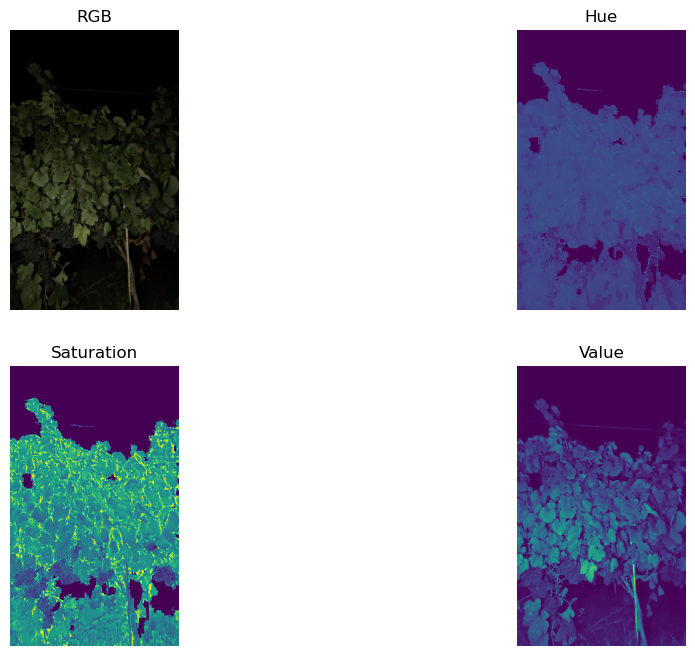

0.9583333333333334


In [4]:
Ihsv = imgcolor.rgb2hsv(Irgb)
Ihv  = Ihsv[:,:,::2] # canales 0 y 2
Ih   = Ihsv[:,:,0]
#
# vemos algunos ejemplos de distintas representaciones y sus canales
#
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(Irgb)
plt.axis('off')
plt.title('RGB')
plt.subplot(2,2,2)
plt.imshow(Ihsv[:,:,0])
plt.axis('off')
plt.title('Hue')
plt.subplot(2,2,3)
plt.imshow(Ihsv[:,:,1])
plt.axis('off')
plt.title('Saturation')
plt.subplot(2,2,4)
plt.imshow(Ihsv[:,:,2])
plt.axis('off')
plt.title('Value')
plt.show()

#
# cantidad de clusters (modificable)
#
M,N,C = Irgb.shape
#
# datos: aquí podemos elegir entre distintas representaciones
# descomentar la que se quiera usar
#
#Xrgb = np.reshape(Irgb,(M*N,C)).astype(float) # 1 dato = vector RGB
#Xhsv = np.reshape(Ihsv,(M*N,C)) # 1 dato = vector HSV
Xhv  = np.reshape(Ihsv[:,:,0::2],(M*N,2)) # 1 dato = solo Hue (tono) y valor (brillo)
Xrb  = np.reshape(Irgb[:,:,0::2],(M*N,2)) # 1 dato = solo Hue (tono) y valor (brillo)
#Xh   = np.ravel(Ihsv[:,:,0])    # 1 dato = Hue (tono)
#
# cambiar aquí según el espacio que se quiera usar
#
X = Xhv
print(np.max(X))

### Comentarios

Se puede ver que las uvas se distinguen particularmente en los canales Hue y Value. La saturación no aporta nada en este caso.

Tiene sentido entonces quedarse sólo con los canales Hue y Value.

### Exploración de estos canales

Vamos a ver los pixeles en el espacio H-V

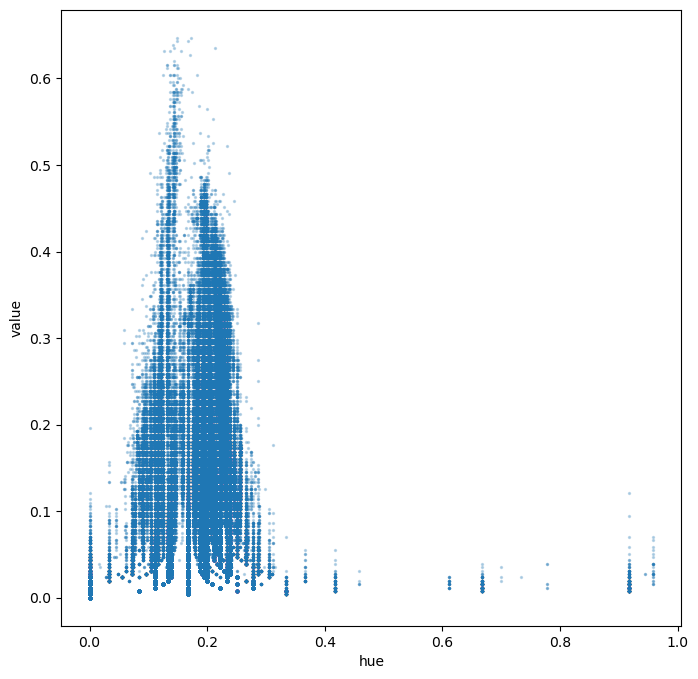

In [5]:
plt.figure(figsize=(8,8))
plt.scatter(Xhv[:,0],Xhv[:,1],s=2,alpha=0.25)
plt.xlabel('hue')
plt.ylabel('value')
plt.show()

### Observaciones

Se ven tres grupos claros con forma de "cluster" propiamente dicha.

Los tres grupos corresponden, al parecer, a tres cosas: lo verde (pasto y hojas) que sería el grupo grande de la izquierda; el cielo, y algunas cosas brillantes, que serían el grupo de arriba, y las uvas, que serían el grupo de más a la izquierda. Hay algo que creo que tiene que ver con las uvas y son las bandas verticales gruesas, que supongo que se deben a los distintos colores de uva (algunos son más rojizos, otros más violetas).
Vamos a ver luego cómo se arman los clusters en base a esta estructura.


In [6]:
#
# el algoritmo kmeans devuelve una asignación de clase para cada dato
# esto puede variar según la semilla usada; el no. de clase es irrelevante
#
k = 3
color_1 = (0.2,0.5)
color_2 = (0.57,1.0) # cielo
color_3 = (0.8,0.25) # uvas
ini_cb = np.array((color_1,color_2,color_3))

np.random.seed(42)
model = KMeans(n_clusters=3,init=ini_cb,n_init=1)
Xvq_class = model.fit_predict(X)
Ivq = np.reshape(Xvq_class,Ihsv.shape[:2])

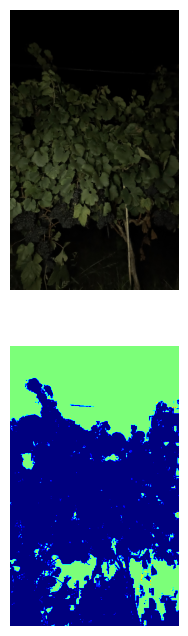

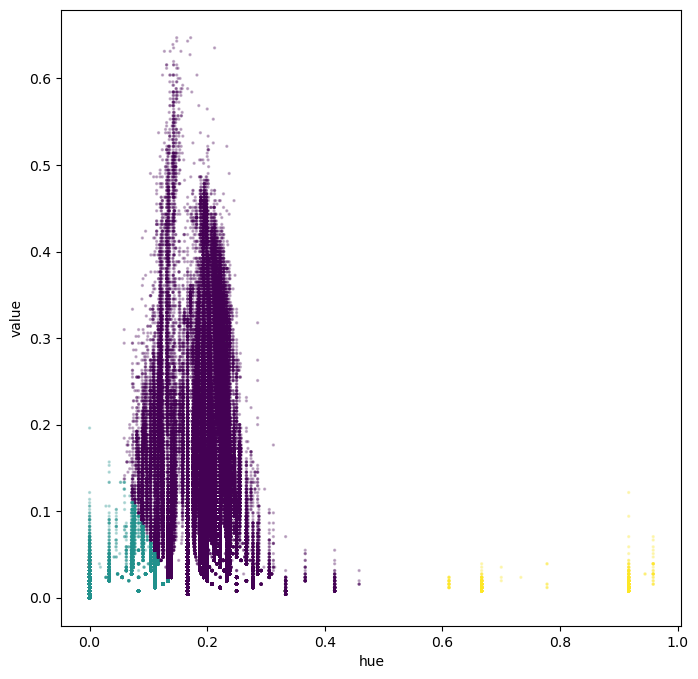

In [8]:
#
# resultados
#
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.imshow(Irgb)
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(Ivq/k,cmap='jet')
plt.axis('off')
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(X[:,0],X[:,1],s=2,alpha=0.25,c=Xvq_class/k)
plt.xlabel('hue')
plt.ylabel('value')
plt.show()


### Comentarios

El K-means anda horrible porque los puntos en el espacio no están claramente separados. Si noestuvieran las lineas verticales, o talvez inicializando con otra semilla, sería más fácil. También se podría usar un método más robusto tipo k-medians, o spectral clustering.


## Otros métodos

Vamos a probar con un método más moderno a ver qué pasa.


number of samples 484920


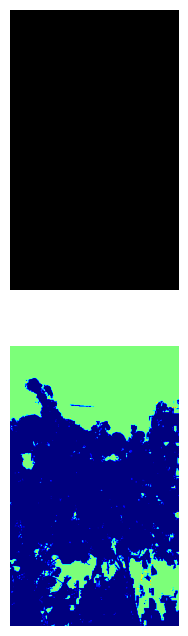

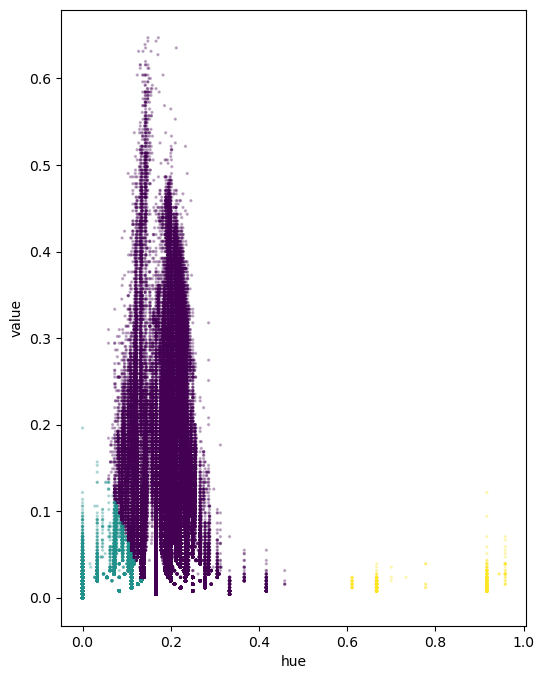

In [9]:
from sklearn import cluster
from sklearn import mixture
k = 3
print('number of samples',len(X))
np.random.seed(42)
#model = cluster.OPTICS() # no da la memoria!
#model = cluster.DBSCAN() # no da la memoria!
#model = cluster.SpectralClustering() # no da tampoco
#model = cluster.AgglomerativeClustering()
#model = cluster.KMeans(n_clusters=3,n_init=10)
#model = mixture.GaussianMixture(n_components=4)
#model = cluster.AgglomerativeClustering(memory="./ag")
Xvq_class = model.fit_predict(X)

Ivq_class = np.reshape(Xvq_class,(M,N)).astype(float)
kauto = np.max(Xvq_class)
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.imshow(Irgb.astype(np.uint8))
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(Ivq_class/k,cmap='jet')
plt.axis('off')
plt.show()

plt.figure(figsize=(6,8))
plt.scatter(X[:,0],X[:,1],s=2,alpha=0.25,c=Xvq_class/k)
plt.xlabel('hue')
plt.ylabel('value')
plt.show()




## Clustering manual

También podemos, con información a priori y asumiendo que las imágenes se toman en condiciones similares, fijar los centroides nosotros y ver qué pasa.



In [10]:
from scipy.cluster import vq
color_1 = (0.2,0.5)
color_2 = (0.57,1.0) # cielo
color_3 = (0.8,0.25) # uvas
codebook_manual = np.array((color_1,color_2,color_3))
print(np.max(X))
Xvq_manual,_    = vq.vq(X,codebook_manual)
Ivq_manual      = np.reshape(Xvq_manual,(M,N)).astype(float)

0.9583333333333334


In [ ]:
plt.figure(figsize=(6,12))
plt.subplot(2,1,1)
plt.imshow(Irgb.astype(np.uint8))
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(Ivq_manual/k,cmap='jet')
plt.axis('off')
plt.show()

plt.figure(figsize=(6,8))
plt.scatter(X[:,0],X[:,1],s=2,alpha=0.25,c=Xvq_manual/3)
plt.xlabel('hue')
plt.ylabel('value')
plt.show()

## Regularización espacial

Como se ve, y es de esperar, hay confusiones en los bordes, que suelen tener colores mezclados.

Para eliminar esto podemos hacer un filtro de mediana de la imagen de clases.


In [ ]:
from skimage import filters

Ivq_manual_med = filters.median(Ivq_manual,footprint=np.ones((13,13)))
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.imshow(Irgb)
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(Ivq_manual_med/k,cmap='jet')
plt.axis('off')
plt.show()



## Medición

Claro que se puede aprender, pero se me ocurre que una buena función a aplicar a la cantidad de pixeles de uvas para estimar el yield es $y=x^{3/2}$. Por qué? Porque lo que vemos es aproximadamente un área, que se relaciona con el diámetro (longitud) en una relación $\mathrm{area}\propto\mathrm{diametro}^2$. El volumen se relaciona $\mathrm{volumen}\propto\mathrm{diametro}^3$. Entonces la relación área-volumen es $\mathrm{volumen}\propto\mathrm{area}^{3/2}$.

El clustering manual tiene dos ventajas:

* Sirve para inicializar un algoritmo automático, como K-means
* Ya nos dice qué cluster corresponde a las uvas. En el caso de arriba, es el 3 (índice 2).

Claro que el "yield" que obtenemos abajo es en pixeles, claramente no es la medida correcta. Habría que hacer una regresión para relacionarlo con el valor de interés.



In [11]:
yield_area = len(np.flatnonzero(Xvq_manual==2))
print(yield_area)

yield_vol = yield_area**(3/2)

print(yield_vol)

813
23181.194900177168
